In [1]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import os

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    cross_val_score,
    train_test_split,
    RepeatedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    learning_curve,
)
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
import kagglehub


c:\Users\diego\Desktop\Data Science\.pgvenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

In [2]:
# Download the dataset
path = kagglehub.dataset_download("denkuznetz/food-delivery-time-prediction")

df = pd.read_csv(os.path.join(path, 'Food_Delivery_Times.csv'))

# Imputate null values
columns = ['Weather', 'Traffic_Level', 'Time_of_Day']
for item in columns:
    df[item] = df[item].fillna(df[item].mode()[0])

columns = ['Courier_Experience_yrs']
for item in columns:
    df[item] = df[item].fillna(df[item].median())
    
y = df["Delivery_Time_min"]
X = df.drop(columns=["Delivery_Time_min"])

# Columns
cat_cols = ["Weather", "Traffic_Level", "Time_of_Day", "Vehicle_Type"]
num_cols = ["Distance_km", "Preparation_Time_min", "Courier_Experience_yrs"]

# Split train-test (hold-out final 15 %)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

# Preprocessing

In [4]:
cat_pipe = Pipeline(
    steps=[
        ("ohe", OneHotEncoder(drop="first", handle_unknown="ignore")),
    ]
)
num_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median"))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[("cat", cat_pipe, cat_cols), ("num", num_pipe, num_cols)]
)

In [5]:
# Check multicollinearity between features
X_dummies = pd.get_dummies(
    X[['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']],
    drop_first=True, dtype=float
)

# Combine dummies with numericas features
X_all = pd.concat([X[['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs']], 
                   X_dummies], axis=1)

# VIF
vif = pd.Series( [variance_inflation_factor(X_all.values, i) for i in range(len(X_all.columns))],
    index=X_all.columns, name="VIF"
).sort_values(ascending=False)

print(vif)

Preparation_Time_min      4.886101
Distance_km               3.526721
Courier_Experience_yrs    3.069041
Traffic_Level_Medium      2.581862
Traffic_Level_Low         2.455733
Time_of_Day_Morning       2.005893
Time_of_Day_Evening       1.887938
Vehicle_Type_Scooter      1.561383
Weather_Rainy             1.398787
Vehicle_Type_Car          1.377977
Time_of_Day_Night         1.252746
Weather_Snowy             1.206166
Weather_Foggy             1.185267
Weather_Windy             1.181973
Name: VIF, dtype: float64


# Models

## Ridge

In [6]:
ridge_pipe = Pipeline(steps=[("prep", preprocessor), ("reg", Ridge())])

ridge_param_grid = {
    "reg__alpha": [0.0, 0.01, 0.1, 1.0, 10.0],
    "reg__fit_intercept": [True, False],
}

ridge_grid = GridSearchCV(
    ridge_pipe,
    ridge_param_grid,
    scoring="neg_mean_absolute_error",
    cv=cv,
    n_jobs=-1,
    refit=True,
    return_train_score=True,
)
ridge_grid.fit(X_train_full, y_train_full)


,estimator,"Pipeline(step...g', Ridge())])"
,param_grid,"{'reg__alpha': [0.0, 0.01, ...], 'reg__fit_intercept': [True, False]}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,RepeatedKFold...ndom_state=42)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,transformers,"[('cat', ...), ('num', ...)]"


## Linear Regression

In [28]:
ols_pipe = Pipeline([("prep", preprocessor), ("reg", LinearRegression())])

ols_cv_mae = -cross_val_score(
    ols_pipe, X_train_full, y_train_full,
    scoring="neg_mean_absolute_error", cv=cv, n_jobs=-1
).mean()

ols_pipe.fit(X_train_full, y_train_full)
mae_test_ols = mean_absolute_error(y_test, ols_pipe.predict(X_test))

## Random Forest

In [17]:
rf_pipe = Pipeline(steps=[("prep", preprocessor), ("reg", RandomForestRegressor())])

rf_param_dist = {
    "reg__n_estimators" : [300, 600, 1000],
    "reg__max_depth" : [5, 8, 12, None],
    "reg__min_samples_leaf" : [2, 5, 10],
    "reg__min_samples_split" : [2, 5, 10],
    "reg__max_features" : ["sqrt", 0.5, None],
    "reg__max_samples" : [0.6, 0.8, None],
}

rf_search = RandomizedSearchCV(
    rf_pipe,
    rf_param_dist,
    n_iter=15,
    scoring="neg_mean_absolute_error",
    cv=cv,
    random_state=42,
    n_jobs=-1,
    refit=True,
    return_train_score=True,
)
rf_search.fit(X_train_full, y_train_full)


,estimator,Pipeline(step...Regressor())])
,param_distributions,"{'reg__max_depth': [5, 8, ...], 'reg__max_features': ['sqrt', 0.5, ...], 'reg__max_samples': [0.6, 0.8, ...], 'reg__min_samples_leaf': [2, 5, ...], ...}"
,n_iter,15
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,RepeatedKFold...ndom_state=42)
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


## XGBoost

In [ ]:
# Optuna 
def xgb_objective(trial):
    params = {
        "n_estimators"      : trial.suggest_int(  "n_estimators",      300, 1200),
        "learning_rate"     : trial.suggest_float("learning_rate",   0.01, 0.20, log=True),
        "max_depth"         : trial.suggest_int(  "max_depth",           3, 10),
        "min_child_weight"  : trial.suggest_float("min_child_weight",  1.0, 10.0),
        "subsample"         : trial.suggest_float("subsample",        0.60, 1.00),
        "colsample_bytree"  : trial.suggest_float("colsample_bytree", 0.60, 1.00),
        "gamma"             : trial.suggest_float("gamma",            0.0,  5.0),
        "reg_alpha"         : trial.suggest_float("reg_alpha",        0.0,  5.0),
        "reg_lambda"        : trial.suggest_float("reg_lambda",       0.1,  5.0),
        "random_state"      : 42,
        "n_jobs"            : -1,
        "objective"         : "reg:squarederror",
        "tree_method"       : "hist",
    }

    xgb_pipe = Pipeline([
        ("prep", preprocessor),
        ("reg",  XGBRegressor(**params)),
    ])

    scores = cross_val_score(
        xgb_pipe,
        X_train_full, y_train_full,
        scoring="neg_mean_absolute_error",
        cv=cv, n_jobs=-1,
    )
    return -scores.mean()

# Deploy the optuna study to find the best parameters
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(),
    pruner = optuna.pruners.MedianPruner(n_warmup_steps=5),
)
study.optimize(xgb_objective, n_trials=50, show_progress_bar=True)

print("Best CV-MAE :", study.best_value)
print("Best params :", study.best_params)

best_xgb_pipe = Pipeline([
    ("prep", preprocessor),
    ("reg",  XGBRegressor(**study.best_params)),
])
best_xgb_pipe.fit(X_train_full, y_train_full)

[I 2025-07-03 20:16:09,749] A new study created in memory with name: no-name-f1c44ed7-5e9e-4894-ba5e-fa48bf3f07ff
Best trial: 0. Best value: 7.16961:   2%|▏         | 1/50 [00:00<00:30,  1.60it/s]

[I 2025-07-03 20:16:10,372] Trial 0 finished with value: 7.169606479008992 and parameters: {'n_estimators': 976, 'learning_rate': 0.012949980672402937, 'max_depth': 3, 'min_child_weight': 8.575834564015052, 'subsample': 0.8040172143570468, 'colsample_bytree': 0.9835685693341868, 'gamma': 1.554039933959075, 'reg_alpha': 3.98870607168727, 'reg_lambda': 1.8184738308563109}. Best is trial 0 with value: 7.169606479008992.


Best trial: 0. Best value: 7.16961:   4%|▍         | 2/50 [00:01<00:38,  1.24it/s]

[I 2025-07-03 20:16:11,309] Trial 1 finished with value: 7.56560575167338 and parameters: {'n_estimators': 564, 'learning_rate': 0.015602142282950485, 'max_depth': 8, 'min_child_weight': 7.405361850473345, 'subsample': 0.7776735397996128, 'colsample_bytree': 0.7416868541358705, 'gamma': 3.1999040367136304, 'reg_alpha': 2.8017575652260875, 'reg_lambda': 3.2402071327549895}. Best is trial 0 with value: 7.169606479008992.


Best trial: 0. Best value: 7.16961:   6%|▌         | 3/50 [00:02<00:44,  1.05it/s]

[I 2025-07-03 20:16:12,434] Trial 2 finished with value: 7.871788946787516 and parameters: {'n_estimators': 472, 'learning_rate': 0.026730955152991245, 'max_depth': 9, 'min_child_weight': 5.406649258852794, 'subsample': 0.6343865599463979, 'colsample_bytree': 0.9774469511470866, 'gamma': 2.670697422101374, 'reg_alpha': 1.7106575416758645, 'reg_lambda': 0.4565425744628432}. Best is trial 0 with value: 7.169606479008992.


Best trial: 0. Best value: 7.16961:   8%|▊         | 4/50 [00:03<00:37,  1.22it/s]

[I 2025-07-03 20:16:13,053] Trial 3 finished with value: 8.2121688524882 and parameters: {'n_estimators': 465, 'learning_rate': 0.07092414316010463, 'max_depth': 5, 'min_child_weight': 3.518250802215527, 'subsample': 0.7179513008863267, 'colsample_bytree': 0.6762717654858927, 'gamma': 0.5068105738627465, 'reg_alpha': 4.289126323732843, 'reg_lambda': 0.2517039420639977}. Best is trial 0 with value: 7.169606479008992.


Best trial: 0. Best value: 7.16961:  10%|█         | 5/50 [00:03<00:32,  1.38it/s]

[I 2025-07-03 20:16:13,610] Trial 4 finished with value: 8.314496660232544 and parameters: {'n_estimators': 749, 'learning_rate': 0.16795801815463998, 'max_depth': 6, 'min_child_weight': 2.0553986353069513, 'subsample': 0.9128780638514905, 'colsample_bytree': 0.8591558694413057, 'gamma': 3.027152585489474, 'reg_alpha': 3.1308143861839977, 'reg_lambda': 1.5649299810913457}. Best is trial 0 with value: 7.169606479008992.


Best trial: 0. Best value: 7.16961:  12%|█▏        | 6/50 [00:04<00:32,  1.37it/s]

[I 2025-07-03 20:16:14,349] Trial 5 finished with value: 8.310794846216838 and parameters: {'n_estimators': 1153, 'learning_rate': 0.1390400681699579, 'max_depth': 10, 'min_child_weight': 3.8194336109046976, 'subsample': 0.6422140793049904, 'colsample_bytree': 0.7645464191588461, 'gamma': 4.766629315973103, 'reg_alpha': 4.772676064534756, 'reg_lambda': 2.1401236122725873}. Best is trial 0 with value: 7.169606479008992.


Best trial: 0. Best value: 7.16961:  14%|█▍        | 7/50 [00:05<00:30,  1.40it/s]

[I 2025-07-03 20:16:15,036] Trial 6 finished with value: 8.459681034088135 and parameters: {'n_estimators': 813, 'learning_rate': 0.13618330374662208, 'max_depth': 9, 'min_child_weight': 5.224332457709098, 'subsample': 0.6618270764014508, 'colsample_bytree': 0.8647554401008224, 'gamma': 4.068662113141873, 'reg_alpha': 2.65264055565339, 'reg_lambda': 2.4151873601712395}. Best is trial 0 with value: 7.169606479008992.


Best trial: 0. Best value: 7.16961:  16%|█▌        | 8/50 [00:05<00:28,  1.46it/s]

[I 2025-07-03 20:16:15,658] Trial 7 finished with value: 8.141642904281616 and parameters: {'n_estimators': 938, 'learning_rate': 0.17266113609584274, 'max_depth': 8, 'min_child_weight': 1.8539439176282706, 'subsample': 0.8006647841814094, 'colsample_bytree': 0.8812463722496093, 'gamma': 0.7681314012780133, 'reg_alpha': 0.1843143854536322, 'reg_lambda': 4.515992246031322}. Best is trial 0 with value: 7.169606479008992.


Best trial: 0. Best value: 7.16961:  18%|█▊        | 9/50 [00:07<00:33,  1.23it/s]

[I 2025-07-03 20:16:16,760] Trial 8 finished with value: 7.796794001261393 and parameters: {'n_estimators': 577, 'learning_rate': 0.02244059217615375, 'max_depth': 8, 'min_child_weight': 1.9573154309196554, 'subsample': 0.8035960053294549, 'colsample_bytree': 0.8475434836414734, 'gamma': 4.956106355583186, 'reg_alpha': 0.1762826338820278, 'reg_lambda': 4.852944594740988}. Best is trial 0 with value: 7.169606479008992.


Best trial: 0. Best value: 7.16961:  20%|██        | 10/50 [00:07<00:31,  1.29it/s]

[I 2025-07-03 20:16:17,451] Trial 9 finished with value: 7.6865467230478925 and parameters: {'n_estimators': 1013, 'learning_rate': 0.028112671990344083, 'max_depth': 4, 'min_child_weight': 4.922771839701415, 'subsample': 0.9709395228459857, 'colsample_bytree': 0.6329265603028503, 'gamma': 2.7023602393187076, 'reg_alpha': 2.887438044767905, 'reg_lambda': 3.922371877530894}. Best is trial 0 with value: 7.169606479008992.


Best trial: 0. Best value: 7.16961:  22%|██▏       | 11/50 [00:08<00:28,  1.36it/s]

[I 2025-07-03 20:16:18,095] Trial 10 finished with value: 7.234410381317138 and parameters: {'n_estimators': 1137, 'learning_rate': 0.013857918342631776, 'max_depth': 3, 'min_child_weight': 9.960133162339044, 'subsample': 0.8736104708567493, 'colsample_bytree': 0.9936721293358578, 'gamma': 1.291422920081459, 'reg_alpha': 3.953659447143743, 'reg_lambda': 1.4433730280161199}. Best is trial 0 with value: 7.169606479008992.


Best trial: 0. Best value: 7.16961:  24%|██▍       | 12/50 [00:09<00:29,  1.30it/s]

[I 2025-07-03 20:16:18,933] Trial 11 finished with value: 7.179866743087769 and parameters: {'n_estimators': 1200, 'learning_rate': 0.010178561961594194, 'max_depth': 3, 'min_child_weight': 9.957732928171664, 'subsample': 0.8753086870332369, 'colsample_bytree': 0.9948468000793038, 'gamma': 1.479569315381198, 'reg_alpha': 3.9801505536377517, 'reg_lambda': 1.3762795834806165}. Best is trial 0 with value: 7.169606479008992.


Best trial: 12. Best value: 7.16321:  26%|██▌       | 13/50 [00:09<00:26,  1.40it/s]

[I 2025-07-03 20:16:19,527] Trial 12 finished with value: 7.163213125864664 and parameters: {'n_estimators': 1012, 'learning_rate': 0.0111924495769983, 'max_depth': 3, 'min_child_weight': 9.847060852507227, 'subsample': 0.8772753974648129, 'colsample_bytree': 0.9388438135782519, 'gamma': 1.6605827471870225, 'reg_alpha': 3.80929167123539, 'reg_lambda': 1.295359638860784}. Best is trial 12 with value: 7.163213125864664.


Best trial: 12. Best value: 7.16321:  28%|██▊       | 14/50 [00:10<00:26,  1.36it/s]

[I 2025-07-03 20:16:20,306] Trial 13 finished with value: 8.251350911458333 and parameters: {'n_estimators': 955, 'learning_rate': 0.04404687935973418, 'max_depth': 5, 'min_child_weight': 8.354432047269313, 'subsample': 0.9532228927596658, 'colsample_bytree': 0.9498411675563987, 'gamma': 1.8787719313120923, 'reg_alpha': 1.6224434936395484, 'reg_lambda': 0.8446171140792126}. Best is trial 12 with value: 7.163213125864664.


Best trial: 12. Best value: 7.16321:  30%|███       | 15/50 [00:11<00:24,  1.42it/s]

[I 2025-07-03 20:16:20,945] Trial 14 finished with value: 7.249251015981039 and parameters: {'n_estimators': 787, 'learning_rate': 0.010367777061586505, 'max_depth': 4, 'min_child_weight': 7.682374926902984, 'subsample': 0.8405383514475249, 'colsample_bytree': 0.9216278857579191, 'gamma': 1.987182836591731, 'reg_alpha': 3.497915365739475, 'reg_lambda': 3.040415174706828}. Best is trial 12 with value: 7.163213125864664.


Best trial: 12. Best value: 7.16321:  32%|███▏      | 16/50 [00:11<00:22,  1.49it/s]

[I 2025-07-03 20:16:21,536] Trial 15 finished with value: 7.239829349517822 and parameters: {'n_estimators': 1024, 'learning_rate': 0.017497809433009114, 'max_depth': 3, 'min_child_weight': 8.468805131027104, 'subsample': 0.7428289914668648, 'colsample_bytree': 0.9110839585726344, 'gamma': 0.03184089633791509, 'reg_alpha': 4.879880182232755, 'reg_lambda': 1.854344246096646}. Best is trial 12 with value: 7.163213125864664.


Best trial: 12. Best value: 7.16321:  34%|███▍      | 17/50 [00:12<00:23,  1.39it/s]

[I 2025-07-03 20:16:22,362] Trial 16 finished with value: 8.169419225056966 and parameters: {'n_estimators': 864, 'learning_rate': 0.041313261653066875, 'max_depth': 6, 'min_child_weight': 7.078762661344766, 'subsample': 0.9190969944293298, 'colsample_bytree': 0.8120791296800239, 'gamma': 2.062210265182893, 'reg_alpha': 2.185765631344151, 'reg_lambda': 1.0555697228225174}. Best is trial 12 with value: 7.163213125864664.


Best trial: 12. Best value: 7.16321:  36%|███▌      | 18/50 [00:13<00:20,  1.53it/s]

[I 2025-07-03 20:16:22,861] Trial 17 finished with value: 8.099584595362346 and parameters: {'n_estimators': 654, 'learning_rate': 0.06768269358983336, 'max_depth': 4, 'min_child_weight': 6.516716058163322, 'subsample': 0.8435987512075507, 'colsample_bytree': 0.9322017150946633, 'gamma': 1.2896674696159405, 'reg_alpha': 3.5025608348811215, 'reg_lambda': 2.849279590660163}. Best is trial 12 with value: 7.163213125864664.


Best trial: 12. Best value: 7.16321:  38%|███▊      | 19/50 [00:13<00:17,  1.81it/s]

[I 2025-07-03 20:16:23,179] Trial 18 finished with value: 7.327556959788004 and parameters: {'n_estimators': 312, 'learning_rate': 0.021247904717544435, 'max_depth': 5, 'min_child_weight': 8.843074590837258, 'subsample': 0.7368691679258561, 'colsample_bytree': 0.8164727724801598, 'gamma': 3.4998306010553564, 'reg_alpha': 4.381225368747984, 'reg_lambda': 0.872912513990123}. Best is trial 12 with value: 7.163213125864664.


Best trial: 12. Best value: 7.16321:  40%|████      | 20/50 [00:14<00:16,  1.77it/s]

[I 2025-07-03 20:16:23,778] Trial 19 finished with value: 7.264709854125977 and parameters: {'n_estimators': 1072, 'learning_rate': 0.01290543150770859, 'max_depth': 3, 'min_child_weight': 9.138676039347954, 'subsample': 0.9897782692921295, 'colsample_bytree': 0.9544863678630239, 'gamma': 0.7822390685665823, 'reg_alpha': 3.523196535086589, 'reg_lambda': 3.6834904243150723}. Best is trial 12 with value: 7.163213125864664.


Best trial: 12. Best value: 7.16321:  42%|████▏     | 21/50 [00:15<00:20,  1.40it/s]

[I 2025-07-03 20:16:24,845] Trial 20 finished with value: 8.164557647705077 and parameters: {'n_estimators': 897, 'learning_rate': 0.033063049789438026, 'max_depth': 7, 'min_child_weight': 6.416738182209006, 'subsample': 0.700842980167126, 'colsample_bytree': 0.9010753621201908, 'gamma': 2.3068154827733043, 'reg_alpha': 2.122721490351167, 'reg_lambda': 2.0939027790244413}. Best is trial 12 with value: 7.163213125864664.


Best trial: 12. Best value: 7.16321:  44%|████▍     | 22/50 [00:15<00:20,  1.39it/s]

[I 2025-07-03 20:16:25,573] Trial 21 finished with value: 7.185251617431641 and parameters: {'n_estimators': 1196, 'learning_rate': 0.010526685029631689, 'max_depth': 3, 'min_child_weight': 9.935791204413894, 'subsample': 0.8892187265252623, 'colsample_bytree': 0.9991917224645901, 'gamma': 1.494063054917094, 'reg_alpha': 4.086845561371815, 'reg_lambda': 1.3044162113163538}. Best is trial 12 with value: 7.163213125864664.


Best trial: 12. Best value: 7.16321:  46%|████▌     | 23/50 [00:16<00:19,  1.37it/s]

[I 2025-07-03 20:16:26,330] Trial 22 finished with value: 7.373488473892212 and parameters: {'n_estimators': 1102, 'learning_rate': 0.011039210574025939, 'max_depth': 4, 'min_child_weight': 9.363018904272307, 'subsample': 0.8337293183433313, 'colsample_bytree': 0.9699207649677183, 'gamma': 1.4541030364942433, 'reg_alpha': 3.7979414690726006, 'reg_lambda': 1.6925569583448845}. Best is trial 12 with value: 7.163213125864664.


Best trial: 12. Best value: 7.16321:  48%|████▊     | 24/50 [00:17<00:17,  1.45it/s]

[I 2025-07-03 20:16:26,919] Trial 23 finished with value: 7.304931751887003 and parameters: {'n_estimators': 1030, 'learning_rate': 0.018721803978988826, 'max_depth': 3, 'min_child_weight': 8.04219775791396, 'subsample': 0.8633440174262831, 'colsample_bytree': 0.9999807700737408, 'gamma': 1.6618765055954408, 'reg_alpha': 4.542289906144527, 'reg_lambda': 2.4338161071955704}. Best is trial 12 with value: 7.163213125864664.


Best trial: 12. Best value: 7.16321:  50%|█████     | 25/50 [00:18<00:18,  1.36it/s]

[I 2025-07-03 20:16:27,764] Trial 24 finished with value: 7.506835953394572 and parameters: {'n_estimators': 1198, 'learning_rate': 0.012829414125803127, 'max_depth': 4, 'min_child_weight': 9.38137907343724, 'subsample': 0.9253983329849023, 'colsample_bytree': 0.9468923988789375, 'gamma': 0.850399321061049, 'reg_alpha': 3.310362778576712, 'reg_lambda': 0.5453615669493009}. Best is trial 12 with value: 7.163213125864664.


Best trial: 12. Best value: 7.16321:  52%|█████▏    | 26/50 [00:18<00:16,  1.46it/s]

[I 2025-07-03 20:16:28,331] Trial 25 finished with value: 7.197412776947021 and parameters: {'n_estimators': 986, 'learning_rate': 0.015700162110297452, 'max_depth': 3, 'min_child_weight': 9.666306783299824, 'subsample': 0.7788832921128743, 'colsample_bytree': 0.896537051595059, 'gamma': 2.3367392569182805, 'reg_alpha': 4.0413677787719156, 'reg_lambda': 1.2292956294833541}. Best is trial 12 with value: 7.163213125864664.


Best trial: 12. Best value: 7.16321:  54%|█████▍    | 27/50 [00:19<00:17,  1.33it/s]

[I 2025-07-03 20:16:29,238] Trial 26 finished with value: 8.657883532842 and parameters: {'n_estimators': 1092, 'learning_rate': 0.07057014603383896, 'max_depth': 5, 'min_child_weight': 8.903035956118337, 'subsample': 0.8879917361406545, 'colsample_bytree': 0.9678093775713222, 'gamma': 1.0270086676903443, 'reg_alpha': 0.8358038447974114, 'reg_lambda': 1.9714146000861699}. Best is trial 12 with value: 7.163213125864664.


Best trial: 12. Best value: 7.16321:  56%|█████▌    | 28/50 [00:20<00:15,  1.40it/s]

[I 2025-07-03 20:16:29,867] Trial 27 finished with value: 7.311979707082113 and parameters: {'n_estimators': 846, 'learning_rate': 0.010217630038952187, 'max_depth': 4, 'min_child_weight': 6.782138315519133, 'subsample': 0.819856123018425, 'colsample_bytree': 0.9351874634855175, 'gamma': 0.2617733891975256, 'reg_alpha': 3.7599999536402184, 'reg_lambda': 0.7653713243329985}. Best is trial 12 with value: 7.163213125864664.


Best trial: 12. Best value: 7.16321:  58%|█████▊    | 29/50 [00:20<00:15,  1.40it/s]

[I 2025-07-03 20:16:30,587] Trial 28 finished with value: 7.730388800303142 and parameters: {'n_estimators': 723, 'learning_rate': 0.021678931547804058, 'max_depth': 6, 'min_child_weight': 7.9606639343544945, 'subsample': 0.775558145182635, 'colsample_bytree': 0.7635404873389695, 'gamma': 1.7447092579253087, 'reg_alpha': 4.5578433924014154, 'reg_lambda': 2.66817858240662}. Best is trial 12 with value: 7.163213125864664.


Best trial: 29. Best value: 7.14507:  60%|██████    | 30/50 [00:21<00:13,  1.53it/s]

[I 2025-07-03 20:16:31,093] Trial 29 finished with value: 7.145072301228841 and parameters: {'n_estimators': 919, 'learning_rate': 0.014989116792857908, 'max_depth': 3, 'min_child_weight': 7.375389813481014, 'subsample': 0.9502204686604003, 'colsample_bytree': 0.6974788738267398, 'gamma': 3.164568531418942, 'reg_alpha': 2.9258388387569267, 'reg_lambda': 3.3708612549554102}. Best is trial 29 with value: 7.145072301228841.


Best trial: 29. Best value: 7.14507:  62%|██████▏   | 31/50 [00:22<00:14,  1.32it/s]

[I 2025-07-03 20:16:32,098] Trial 30 finished with value: 7.773610083262126 and parameters: {'n_estimators': 911, 'learning_rate': 0.0144049008067221, 'max_depth': 7, 'min_child_weight': 7.26220816219156, 'subsample': 0.9405088707525744, 'colsample_bytree': 0.6926609925547873, 'gamma': 3.55370551981824, 'reg_alpha': 3.072415930036642, 'reg_lambda': 3.502597592499631}. Best is trial 29 with value: 7.145072301228841.


Best trial: 29. Best value: 7.14507:  64%|██████▍   | 32/50 [00:22<00:12,  1.42it/s]

[I 2025-07-03 20:16:32,676] Trial 31 finished with value: 7.205509344736735 and parameters: {'n_estimators': 1066, 'learning_rate': 0.016404070319350463, 'max_depth': 3, 'min_child_weight': 8.644336076402672, 'subsample': 0.8994875051051208, 'colsample_bytree': 0.7227518555152981, 'gamma': 3.0554988923239628, 'reg_alpha': 2.301881879788655, 'reg_lambda': 3.316149177092438}. Best is trial 29 with value: 7.145072301228841.


Best trial: 29. Best value: 7.14507:  66%|██████▌   | 33/50 [00:23<00:11,  1.45it/s]

[I 2025-07-03 20:16:33,329] Trial 32 finished with value: 7.355250628789266 and parameters: {'n_estimators': 958, 'learning_rate': 0.012898149538420722, 'max_depth': 4, 'min_child_weight': 5.846827290546153, 'subsample': 0.8603818182679192, 'colsample_bytree': 0.6022290867070206, 'gamma': 2.6073510843803183, 'reg_alpha': 2.7282113263885894, 'reg_lambda': 2.3294062082063434}. Best is trial 29 with value: 7.145072301228841.


Best trial: 33. Best value: 7.07113:  68%|██████▊   | 34/50 [00:24<00:10,  1.58it/s]

[I 2025-07-03 20:16:33,829] Trial 33 finished with value: 7.071130577723185 and parameters: {'n_estimators': 880, 'learning_rate': 0.012538541271403341, 'max_depth': 3, 'min_child_weight': 7.566138404821288, 'subsample': 0.7836790561851809, 'colsample_bytree': 0.6810980801257709, 'gamma': 2.255152443270474, 'reg_alpha': 4.196554944218133, 'reg_lambda': 3.924149271739897}. Best is trial 33 with value: 7.071130577723185.


Best trial: 33. Best value: 7.07113:  70%|███████   | 35/50 [00:24<00:08,  1.69it/s]

[I 2025-07-03 20:16:34,322] Trial 34 finished with value: 7.294091701507568 and parameters: {'n_estimators': 874, 'learning_rate': 0.026116038148239096, 'max_depth': 3, 'min_child_weight': 7.506613338979177, 'subsample': 0.7701377143678113, 'colsample_bytree': 0.6574194821019219, 'gamma': 3.4078988762378284, 'reg_alpha': 4.303682925860323, 'reg_lambda': 4.360697984760763}. Best is trial 33 with value: 7.071130577723185.


Best trial: 33. Best value: 7.07113:  72%|███████▏  | 36/50 [00:25<00:08,  1.69it/s]

[I 2025-07-03 20:16:34,920] Trial 35 finished with value: 7.464442332585652 and parameters: {'n_estimators': 699, 'learning_rate': 0.01834222085732748, 'max_depth': 5, 'min_child_weight': 6.043344163657182, 'subsample': 0.6968749394085475, 'colsample_bytree': 0.6976664018864834, 'gamma': 3.970485134692436, 'reg_alpha': 1.6479316630842635, 'reg_lambda': 3.885876451867976}. Best is trial 33 with value: 7.071130577723185.


Best trial: 33. Best value: 7.07113:  74%|███████▍  | 37/50 [00:25<00:07,  1.70it/s]

[I 2025-07-03 20:16:35,499] Trial 36 finished with value: 8.475998989741008 and parameters: {'n_estimators': 810, 'learning_rate': 0.09646942661633766, 'max_depth': 4, 'min_child_weight': 4.514495006481462, 'subsample': 0.752057859508412, 'colsample_bytree': 0.7374673924106846, 'gamma': 2.7938536181019447, 'reg_alpha': 3.079335652281279, 'reg_lambda': 4.127994971389006}. Best is trial 33 with value: 7.071130577723185.


Best trial: 33. Best value: 7.07113:  76%|███████▌  | 38/50 [00:26<00:08,  1.38it/s]

[I 2025-07-03 20:16:36,544] Trial 37 finished with value: 8.141294368108113 and parameters: {'n_estimators': 914, 'learning_rate': 0.05468160151723813, 'max_depth': 10, 'min_child_weight': 2.660991289682501, 'subsample': 0.6003636076077744, 'colsample_bytree': 0.660327243680172, 'gamma': 2.229226219606385, 'reg_alpha': 3.6296596761394824, 'reg_lambda': 3.2171431288724905}. Best is trial 33 with value: 7.071130577723185.


Best trial: 33. Best value: 7.07113:  78%|███████▊  | 39/50 [00:27<00:07,  1.44it/s]

[I 2025-07-03 20:16:37,165] Trial 38 finished with value: 7.822354078292847 and parameters: {'n_estimators': 766, 'learning_rate': 0.03547564652374848, 'max_depth': 9, 'min_child_weight': 8.11463120458671, 'subsample': 0.9994231574842358, 'colsample_bytree': 0.7861209543638099, 'gamma': 3.8838420269703526, 'reg_alpha': 4.952067058420434, 'reg_lambda': 2.8319088605678573}. Best is trial 33 with value: 7.071130577723185.


Best trial: 33. Best value: 7.07113:  80%|████████  | 40/50 [00:28<00:07,  1.32it/s]

[I 2025-07-03 20:16:38,078] Trial 39 finished with value: 7.484161980946859 and parameters: {'n_estimators': 981, 'learning_rate': 0.01228641310828472, 'max_depth': 5, 'min_child_weight': 1.3238222013061822, 'subsample': 0.8110787306117746, 'colsample_bytree': 0.7209760553683456, 'gamma': 2.9430506415388753, 'reg_alpha': 2.490801199618581, 'reg_lambda': 4.923013797158826}. Best is trial 33 with value: 7.071130577723185.


Best trial: 33. Best value: 7.07113:  82%|████████▏ | 41/50 [00:28<00:06,  1.47it/s]

[I 2025-07-03 20:16:38,575] Trial 40 finished with value: 7.19881173769633 and parameters: {'n_estimators': 841, 'learning_rate': 0.015635971585940177, 'max_depth': 3, 'min_child_weight': 7.613628095057015, 'subsample': 0.9594050914413578, 'colsample_bytree': 0.8361265124596113, 'gamma': 1.1185982435688144, 'reg_alpha': 3.2763638025401294, 'reg_lambda': 0.1564032580703838}. Best is trial 33 with value: 7.071130577723185.


Best trial: 33. Best value: 7.07113:  84%|████████▍ | 42/50 [00:29<00:05,  1.49it/s]

[I 2025-07-03 20:16:39,216] Trial 41 finished with value: 7.197271299362183 and parameters: {'n_estimators': 1144, 'learning_rate': 0.011742536041238889, 'max_depth': 3, 'min_child_weight': 9.383411339702302, 'subsample': 0.9072664576195234, 'colsample_bytree': 0.986470639252922, 'gamma': 2.4572640841331643, 'reg_alpha': 4.067793161821151, 'reg_lambda': 1.583005354609243}. Best is trial 33 with value: 7.071130577723185.


Best trial: 33. Best value: 7.07113:  86%|████████▌ | 43/50 [00:30<00:04,  1.56it/s]

[I 2025-07-03 20:16:39,789] Trial 42 finished with value: 7.137869230906168 and parameters: {'n_estimators': 1004, 'learning_rate': 0.01469803102188684, 'max_depth': 3, 'min_child_weight': 8.95627736004119, 'subsample': 0.7885363214736217, 'colsample_bytree': 0.6296025728609413, 'gamma': 4.51072995177258, 'reg_alpha': 4.69081044101371, 'reg_lambda': 1.7407437278381854}. Best is trial 33 with value: 7.071130577723185.


Best trial: 33. Best value: 7.07113:  88%|████████▊ | 44/50 [00:30<00:03,  1.52it/s]

[I 2025-07-03 20:16:40,491] Trial 43 finished with value: 7.574791669845581 and parameters: {'n_estimators': 1047, 'learning_rate': 0.02442355143271269, 'max_depth': 4, 'min_child_weight': 8.548097454768653, 'subsample': 0.776654598205081, 'colsample_bytree': 0.6240843692359095, 'gamma': 4.520954951245128, 'reg_alpha': 4.646671524879309, 'reg_lambda': 4.334638267101651}. Best is trial 33 with value: 7.071130577723185.


Best trial: 33. Best value: 7.07113:  90%|█████████ | 45/50 [00:31<00:03,  1.63it/s]

[I 2025-07-03 20:16:41,002] Trial 44 finished with value: 7.194043286641439 and parameters: {'n_estimators': 943, 'learning_rate': 0.01922790255458409, 'max_depth': 3, 'min_child_weight': 9.005422982466976, 'subsample': 0.7932844266284539, 'colsample_bytree': 0.6418408701639478, 'gamma': 4.234366844367183, 'reg_alpha': 4.3191615486755905, 'reg_lambda': 1.7790547681835207}. Best is trial 33 with value: 7.071130577723185.


Best trial: 33. Best value: 7.07113:  92%|█████████▏| 46/50 [00:31<00:02,  1.54it/s]

[I 2025-07-03 20:16:41,740] Trial 45 finished with value: 7.433572546641032 and parameters: {'n_estimators': 1004, 'learning_rate': 0.014367147234527112, 'max_depth': 4, 'min_child_weight': 6.9823072186621165, 'subsample': 0.8267513726114863, 'colsample_bytree': 0.6800575621646765, 'gamma': 4.481053545936166, 'reg_alpha': 4.7138916289708, 'reg_lambda': 1.061322321482684}. Best is trial 33 with value: 7.071130577723185.


Best trial: 33. Best value: 7.07113:  94%|█████████▍| 47/50 [00:32<00:01,  1.64it/s]

[I 2025-07-03 20:16:42,250] Trial 46 finished with value: 7.111377286911011 and parameters: {'n_estimators': 899, 'learning_rate': 0.014647268787855959, 'max_depth': 3, 'min_child_weight': 7.922793702906368, 'subsample': 0.7948043284661757, 'colsample_bytree': 0.6134416885105689, 'gamma': 4.887085208754646, 'reg_alpha': 4.207208461368971, 'reg_lambda': 2.3353184820927617}. Best is trial 33 with value: 7.071130577723185.


Best trial: 33. Best value: 7.07113:  96%|█████████▌| 48/50 [00:33<00:01,  1.73it/s]

[I 2025-07-03 20:16:42,754] Trial 47 finished with value: 7.399385293324788 and parameters: {'n_estimators': 918, 'learning_rate': 0.029574809898670566, 'max_depth': 3, 'min_child_weight': 7.861137303677456, 'subsample': 0.7211854160919389, 'colsample_bytree': 0.6008361227056275, 'gamma': 4.912318037146933, 'reg_alpha': 3.802538165128628, 'reg_lambda': 2.169577368511515}. Best is trial 33 with value: 7.071130577723185.


Best trial: 33. Best value: 7.07113:  98%|█████████▊| 49/50 [00:33<00:00,  1.76it/s]

[I 2025-07-03 20:16:43,301] Trial 48 finished with value: 7.400961891810099 and parameters: {'n_estimators': 819, 'learning_rate': 0.020011959482384514, 'max_depth': 4, 'min_child_weight': 8.286633827416583, 'subsample': 0.7949772555147494, 'colsample_bytree': 0.6218794646510296, 'gamma': 4.477859023670663, 'reg_alpha': 4.974913283956298, 'reg_lambda': 2.6429033796738812}. Best is trial 33 with value: 7.071130577723185.


Best trial: 33. Best value: 7.07113: 100%|██████████| 50/50 [00:34<00:00,  1.47it/s]

[I 2025-07-03 20:16:43,798] Trial 49 finished with value: 7.093521102269491 and parameters: {'n_estimators': 885, 'learning_rate': 0.014231000521144734, 'max_depth': 3, 'min_child_weight': 6.530470356382646, 'subsample': 0.7536083877050999, 'colsample_bytree': 0.6533777999141199, 'gamma': 4.754149464646776, 'reg_alpha': 4.461151510598662, 'reg_lambda': 3.608567806933291}. Best is trial 33 with value: 7.071130577723185.
Best CV-MAE : 7.071130577723185
Best params : {'n_estimators': 880, 'learning_rate': 0.012538541271403341, 'max_depth': 3, 'min_child_weight': 7.566138404821288, 'subsample': 0.7836790561851809, 'colsample_bytree': 0.6810980801257709, 'gamma': 2.255152443270474, 'reg_alpha': 4.196554944218133, 'reg_lambda': 3.924149271739897}


,steps,"[('prep', ...), ('reg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# Comparison between models

In [19]:
models = {
    "Ridge": ridge_grid,
    'LinearRegression': ols_pipe,
    "RandomForest": rf_search,
    "XGBoost": best_xgb_pipe
}

In [37]:
def evaluate(name, model):
    y_pred_train = model.predict(X_train_full)
    y_pred_test = model.predict(X_test)

    mae_train = mean_absolute_error(y_train_full, y_pred_train)

    if hasattr(model, "best_score_"):                 
        mae_cv = -model.best_score_
    elif name == "XGBoost":                          
        mae_cv = study.best_value
    else:
        scores = cross_val_score(
            model, X_train_full, y_train_full,
            scoring="neg_mean_absolute_error",
            cv=cv, n_jobs=-1
        )
        mae_cv = -scores.mean()
    mae_test = mean_absolute_error(y_test, y_pred_test)

    r2_test = r2_score(y_test, y_pred_test)
    rmse_test = root_mean_squared_error(y_test, y_pred_test)

    print(f"\n{name}: ")
    print(f"MAE (train): {mae_train: .3f}")
    print(f"MAE (test): {mae_test: .3f}")
    print(f"MAE (CV): {mae_cv: .3f}")
    print(f"RMSE (test): {rmse_test: .3f}")
    print(f"R²: {r2_test: .3f}")

for name, model in models.items():
    evaluate(name, model)


Ridge: 
MAE (train):  6.465
MAE (test):  6.383
MAE (CV):  6.603
RMSE (test):  9.586
R²:  0.787

LinearRegression: 
MAE (train):  6.464
MAE (test):  6.369
MAE (CV):  6.604
RMSE (test):  9.565
R²:  0.788

RandomForest: 
MAE (train):  4.354
MAE (test):  7.281
MAE (CV):  7.519
RMSE (test):  10.685
R²:  0.736

XGBoost: 
MAE (train):  5.742
MAE (test):  6.744
MAE (CV):  7.071
RMSE (test):  9.956
R²:  0.771


# Learning Curves

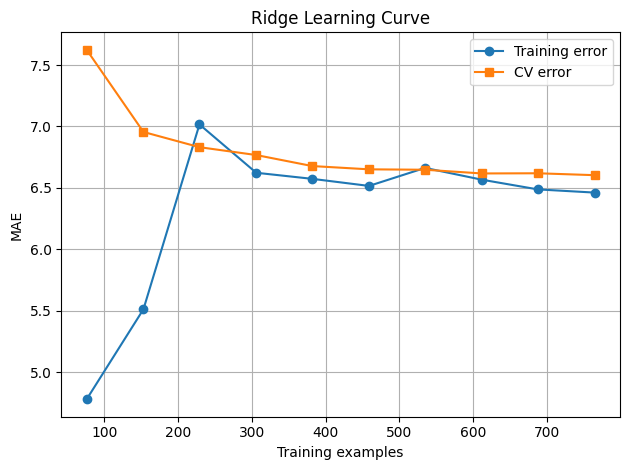

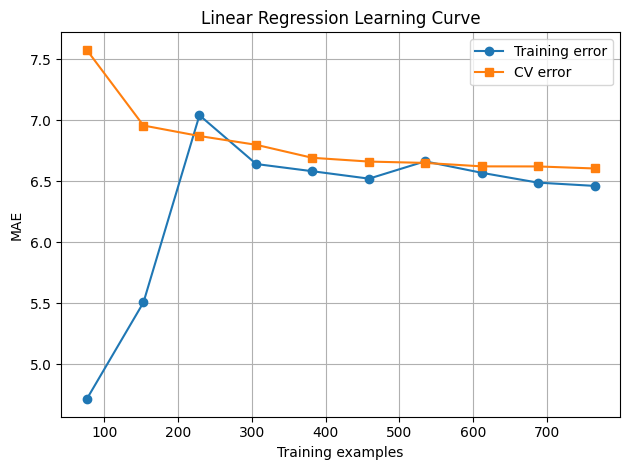

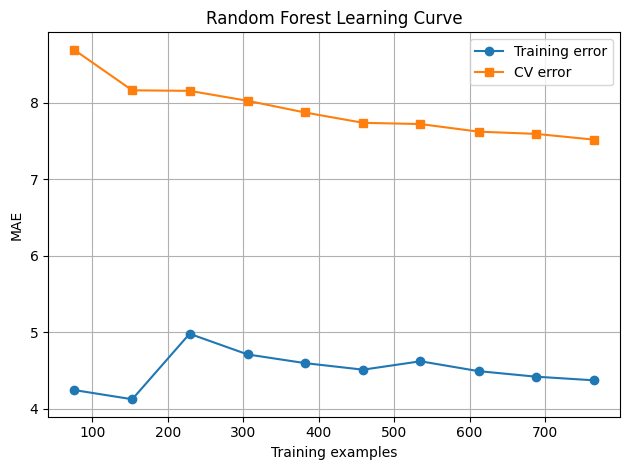

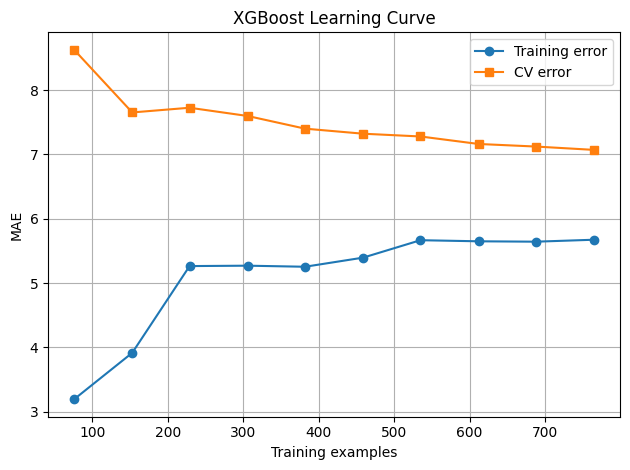

In [ ]:
def plot_learning_curve(estimator, title):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator,
        X_train_full,
        y_train_full,
        cv=cv,
        scoring="neg_mean_absolute_error",
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
    )
    train_scores_mean = -train_scores.mean(axis=1)
    val_scores_mean = -val_scores.mean(axis=1)

    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("MAE")
    plt.plot(train_sizes, train_scores_mean, marker="o", label="Training error")
    plt.plot(train_sizes, val_scores_mean, marker="s", label="CV error")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

plot_learning_curve(ridge_grid.best_estimator_, "Ridge Learning Curve")
plot_learning_curve(ols_pipe, "Linear Regression Learning Curve")
plot_learning_curve(rf_search.best_estimator_, "Random Forest Learning Curve")
plot_learning_curve(best_xgb_pipe, "XGBoost Learning Curve")

# Feature Importance

In [7]:
ridge_model = ridge_grid.best_estimator_.named_steps["reg"]
coefs = ridge_model.coef_

In [8]:
preprocessor = ridge_grid.best_estimator_.named_steps["prep"]
ohe = preprocessor.named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)

# Final list with all the transformed columns
feature_names = list(num_cols) + list(cat_feature_names)

In [9]:
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefs
}).sort_values(by="coefficient", key=abs, ascending=False)

In [13]:
coef_df.head(10).sort_values('coefficient', ascending=False)

,feature,coefficient
2,Courier_Experience_yrs,8.795490
0,Distance_km,5.796781
1,Preparation_Time_min,4.623472
11,Time_of_Day_Night,3.009845
3,Weather_Foggy,1.318463
12,Vehicle_Type_Car,0.973653
10,Time_of_Day_Morning,-0.998489
8,Traffic_Level_Medium,-1.231925
5,Weather_Snowy,-5.252992
4,Weather_Rainy,-11.060862


<Figure size 1000x600 with 0 Axes>

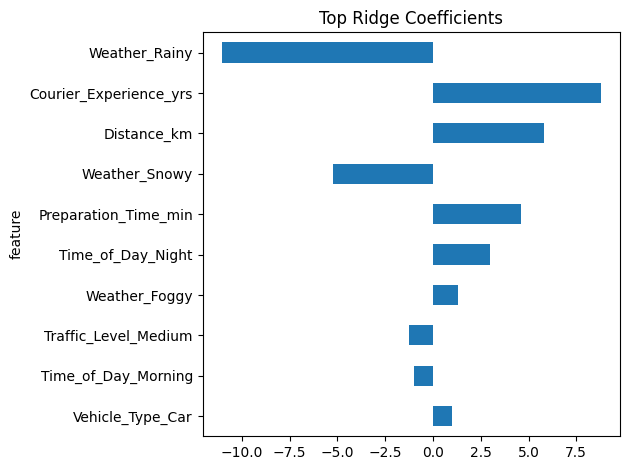

In [14]:
plt.figure(figsize=(10, 6))
coef_df.head(10).plot(kind="barh", x="feature", y="coefficient", legend=False)
plt.title("Top Ridge Coefficients")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()